In [12]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
# Import commonly used libraries 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
from PIL import Image
import matplotlib.image as mpimg
from tqdm import tqdm
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Data Import

In [14]:
# Load the training labels CSV
labels_df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')

# Preview the data
print("First 5 rows:")
print(labels_df.head())

# Summary
print("\nSummary Info:")
print(labels_df.info())

print("\nLabel Distribution:")
print(labels_df['label'].value_counts())


First 5 rows:
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

Summary Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
None

Label Distribution:
label
0    130908
1     89117
Name: count, dtype: int64


## 1. Brief description of the problem and data

**Briefly describe the challenge problem and NLP. Describe the size, dimension, structure, etc., of the data.**
In this dataset, we  are provided with a large number of small pathology images to classify.The goal is to automatically identify metastatic cancer in small image patches taken from lymph node biopsies. Each image is labeled as either:

*  1 – Tumor
*   0 – No Tumor
This is a binary classification task, where each input is a small color image, and the output is a label indicating the presence or absence of cancer cells.

This is a binary classification task, where each input is a small color image, and the output is a label indicating the presence or absence of cancer cells.

The dataset contains:

    1. Images (in train and test folders):

        Size: ~277,524 images in the train folder (may vary slightly by download version).

        Dimensions: Each image is 96×96×3 (RGB).

        Format: .tif images (high-quality image format used in medical imaging).

        The test set contains about 171,000 images for evaluation.

    2. Labels (train_labels.csv):

        Columns:

            id – Image file name (without .tif extension).

            label – 1 if the patch contains tumor tissue, 0 otherwise.

        Size: 1 row per image (≈277,524 rows).


## 2. Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

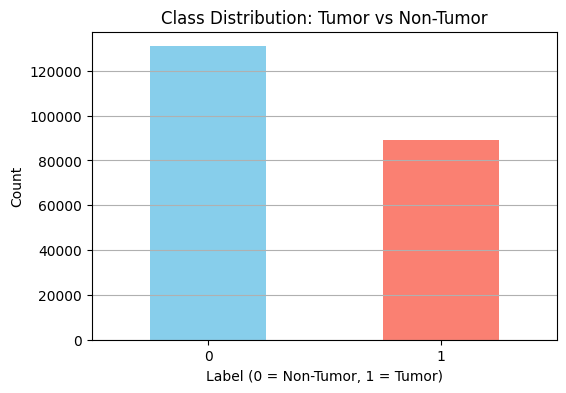

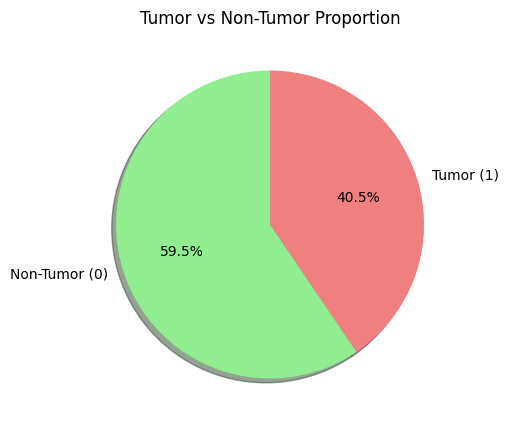

In [15]:
import matplotlib.pyplot as plt

# Bar plot
plt.figure(figsize=(6, 4))
labels_df['label'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution: Tumor vs Non-Tumor')
plt.xlabel('Label (0 = Non-Tumor, 1 = Tumor)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

# Pie chart
plt.figure(figsize=(5, 5))
labels_df['label'].value_counts().plot(
    kind='pie', 
    autopct='%1.1f%%', 
    labels=['Non-Tumor (0)', 'Tumor (1)'],
    colors=['lightgreen', 'lightcoral'],
    startangle=90,
    shadow=True
)
plt.title('Tumor vs Non-Tumor Proportion')
plt.ylabel('')
plt.show()


Label 0 (No Cancer): ~130,000 images,Label 1 (Cancer): ~90,000 images.The dataset is imbalanced, with more non-cancerous patches than cancerous ones. This may bias a CNN model toward predicting class 0

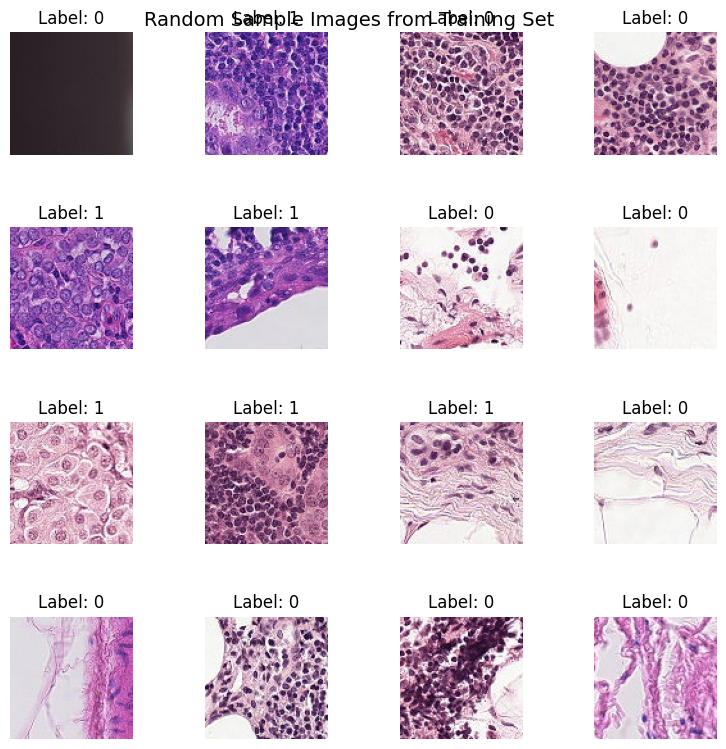

In [16]:

# Path to training images
train_images = '/kaggle/input/histopathologic-cancer-detection/train'

# Sample 16 random images
sample_images = labels_df.sample(16, random_state=42)

# Create 4x4 subplot grid
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
fig.tight_layout(pad=1.5)

# Loop and display each image
for i, ax in enumerate(axes.flat):
    img_id = sample_images.iloc[i]['id']
    label = sample_images.iloc[i]['label']
    
    # Add '.tif' extension
    img_path = os.path.join(train_images, img_id + '.tif')
    
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.set_title(f"Label: {label}")
    ax.axis('off')

plt.suptitle("Random Sample Images from Training Set", fontsize=14)
plt.show()


The images are  collection of cells from a tissue sample. Its resolution 96x96 pixels and it is stored as an RGB image, meaning there are separate channels for red, green, and blue.Both cancerous and non-cancerous images appear to share similar visual characteristics. Each class exhibits considerable diversity, including features like clusters of purple cells, large white areas, and dark regions

100%|██████████| 3000/3000 [00:22<00:00, 134.55it/s]


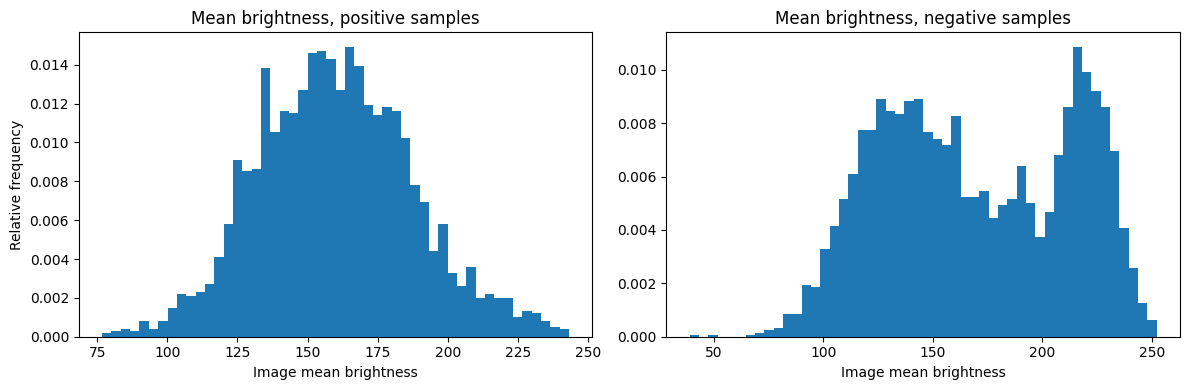

In [17]:

# Path to training images
train_dir = '/kaggle/input/histopathologic-cancer-detection/train'
IMAGE_SIZE = 96

# Initialize brightness lists
brightness_pos = []
brightness_neg = []

# Sample a subset to keep it fast (e.g., 3000 per class)
pos_samples = labels_df[labels_df['label'] == 1].sample(3000, random_state=1)
neg_samples = labels_df[labels_df['label'] == 0].sample(3000, random_state=1)

# Function to calculate mean brightness
def compute_mean_brightness(df, storage_list):
    for img_id in tqdm(df['id']):
        img_path = os.path.join(train_dir, img_id + '.tif')
        img = Image.open(img_path).resize((IMAGE_SIZE, IMAGE_SIZE))
        img_np = np.array(img)
        brightness = img_np.mean()
        storage_list.append(brightness)

# Compute for both classes
compute_mean_brightness(pos_samples, brightness_pos)
compute_mean_brightness(neg_samples, brightness_neg)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(brightness_pos, bins=50, density=True)
axes[0].set_title("Mean brightness, positive samples")
axes[0].set_xlabel("Image mean brightness")
axes[0].set_ylabel("Relative frequency")

axes[1].hist(brightness_neg, bins=50, density=True)
axes[1].set_title("Mean brightness, negative samples")
axes[1].set_xlabel("Image mean brightness")

plt.tight_layout()
plt.show()



From the plot above ,the mean brightness of positive (tumor) samples follows a near-normal distribution centered around 150–160, indicating consistent lighting and tissue density. In contrast, negative (non-tumor) samples show a wider and skewed distribution, with a significant number of images peaking above 200, likely due to large white (background) regions. This suggests that non-tumor images tend to be brighter on average, possibly due to less tissue content.
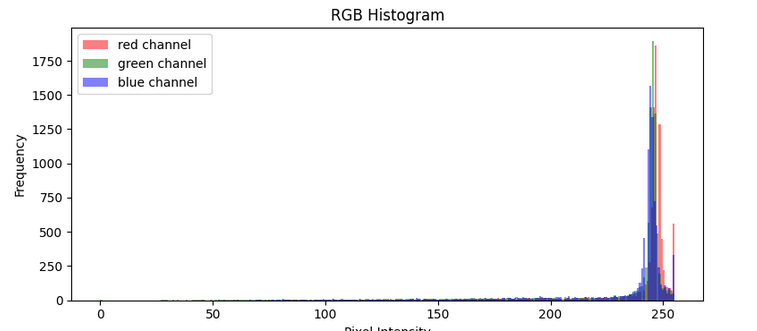

## 3. Data PreProcessing

The original training dataset is quite large, containing 220,025 images of size 96×96×3. Running the model on the full dataset required substantial computational resources, which led to performance issues. To address this, I limited the training set to 50,000 samples and implemented batch loading. This approach ensures that only one batch of images is held in memory at a time, significantly reducing memory usage during training.

The process begins by defining an ImageDataGenerator to rescale pixel values to the [0, 1] range and automatically split the data into 80% training and 20% validation sets.

In [18]:

from sklearn.model_selection import train_test_split

# Directory containing training images
image_dir = '/kaggle/input/histopathologic-cancer-detection/train'
IMAGE_SIZE = 96

# Load a subset (optional: to speed up initial tests)
sample_df = labels_df.sample(50000, random_state=42)  # or use entire labels_df
#sample_df = labels_df.copy()

X = []
y = []

for _, row in tqdm(sample_df.iterrows(), total=len(sample_df)):
    img_id = row['id']
    label = row['label']
    
    img_path = os.path.join(image_dir, img_id + '.tif')
    img = Image.open(img_path).resize((IMAGE_SIZE, IMAGE_SIZE))
    img_array = np.array(img) / 255.0  # normalize to [0, 1]
    
    X.append(img_array)
    y.append(label)

# Convert to NumPy arrays
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.uint8)

print(f"Image data shape: {X.shape}, Labels shape: {y.shape}")


100%|██████████| 50000/50000 [06:09<00:00, 135.42it/s]


Image data shape: (50000, 96, 96, 3), Labels shape: (50000,)


In [19]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")


Training samples: 40000
Validation samples: 10000


In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augmentation for training data
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True
)

# No augmentation for validation data, just normalization
val_datagen = ImageDataGenerator()

# Create generators
train_data = train_datagen.flow(
    X_train, y_train,
    batch_size=32,
    shuffle=True
)

val_data = val_datagen.flow(
    X_val, y_val,
    batch_size=32,
    shuffle=False
)


## 4 . Model Architecture

We’ll begin by building a straightforward and classical convolutional neural network as a baseline model for this task, using the Adam optimizer.

Model architecture:

    Input layer

    Three convolutional blocks, each consisting of:
    [Conv2D × 3 → MaxPooling2D → Dropout] with filter sizes: 16, 32, 64

    Flatten layer

    Dense layer with 256 units

    Dropout layer

    Output layer

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Model parameters (can tune later)
input_shape = (96, 96, 3)
learning_rate = 1e-4
dropout_conv = 0.3
dropout_dense = 0.4

# Build the model
model_cnn = Sequential()

# Block 1
model_cnn.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
model_cnn.add(BatchNormalization())
model_cnn.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Dropout(dropout_conv))

# Block 2
model_cnn.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model_cnn.add(BatchNormalization())
model_cnn.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Dropout(dropout_conv))

# Block 3
model_cnn.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model_cnn.add(BatchNormalization())
model_cnn.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Dropout(dropout_conv))

# Classification head
model_cnn.add(Flatten())
model_cnn.add(Dense(256, activation='relu'))
model_cnn.add(Dropout(dropout_dense))
model_cnn.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile the model
model_cnn.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Show summary
model_cnn.summary()


I0000 00:00:1749138061.216385    1238 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 96, 96, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 96, 96, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 96, 96, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 48, 48, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       4,718,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,007,009 (19.10 MB)

 Trainable params: 5,006,561 (19.10 MB)

 Non-trainable params: 448 (1.75 KB)

In [22]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'),
    ModelCheckpoint('best_cnn_model.h5', save_best_only=True, monitor='val_loss')
]


In [23]:
history = model_cnn.fit(
    train_data,
    validation_data=val_data,
    epochs=15,
    callbacks=callbacks
)


Epoch 1/15


I0000 00:00:1749138067.807202    1284 service.cc:148] XLA service 0x7e4408002cc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749138067.807969    1284 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1749138068.403009    1284 cuda_dnn.cc:529] Loaded cuDNN version 90300


   4/1250 ━━━━━━━━━━━━━━━━━━━━ 1:03 51ms/step - accuracy: 0.5078 - loss: 1.7520

I0000 00:00:1749138074.451288    1284 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 98s 69ms/step - accuracy: 0.7676 - loss: 0.5357 - val_accuracy: 0.6496 - val_loss: 0.6623
Epoch 2/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 84s 67ms/step - accuracy: 0.8284 - loss: 0.4007 - val_accuracy: 0.6753 - val_loss: 0.5706
Epoch 3/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 83s 67ms/step - accuracy: 0.8379 - loss: 0.3812 - val_accuracy: 0.6652 - val_loss: 0.7179
Epoch 4/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 84s 67ms/step - accuracy: 0.8469 - loss: 0.3591 - val_accuracy: 0.7474 - val_loss: 0.5173
Epoch 5/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 84s 67ms/step - accuracy: 0.8513 - loss: 0.3485 - val_accuracy: 0.8094 - val_loss: 0.4117
Epoch 6/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 84s 67ms/step - accuracy: 0.8557 - loss: 0.3350 - val_accuracy: 0.7369 - val_loss: 0.6211
Epoch 7/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 84s 67ms/step - accuracy: 0.8635 - loss: 0.3215 - val_accuracy: 0.8174 - val_loss: 0.4438
Epoch 8/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 84s 67ms/step - accuracy: 0.8759 - loss: 0.30

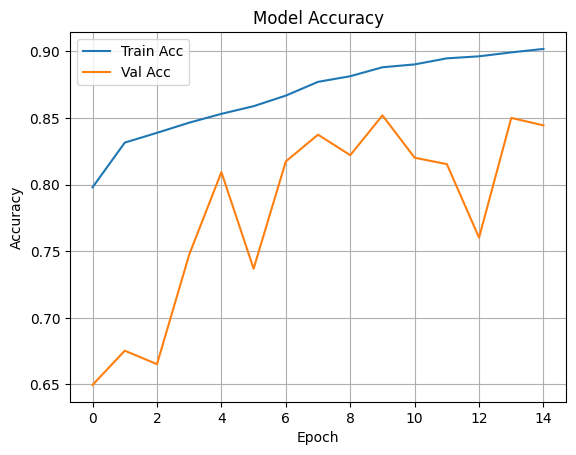

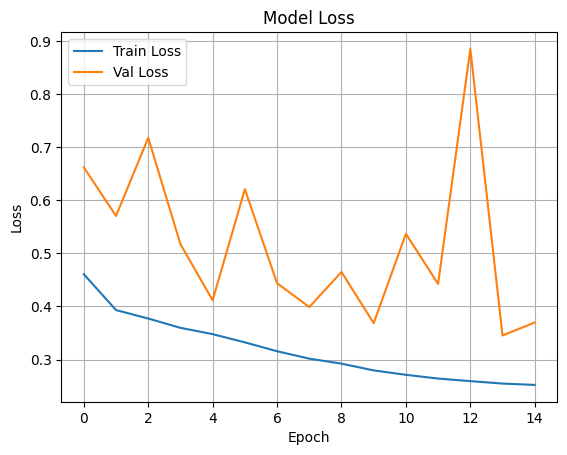

In [24]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Training Accuracy & Loss

    Training accuracy steadily improves to ~89%, indicating that the model is learning well on the training data.

    Training loss consistently decreases — smooth and stable.

Validation accuracy fluctuates between ~60% and ~87%, with no stable upward trend.

Validation loss is highly unstable and much higher than training loss, suggesting the model overfits quickly.

### Transfer learning 
Next I tried efficient transfer learning 

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import SGD

# Hyperparameters
kernel_size = (3, 3)
pool_size = (2, 2)
first_filters = 32
second_filters = 64
third_filters = 128
dropout_conv = 0.3
dropout_dense = 0.4

# Model definition
model_cnn2 = Sequential([
    # Block 1
    Conv2D(first_filters, kernel_size, activation='relu', input_shape=(96, 96, 3)),
    BatchNormalization(),
    Conv2D(first_filters, kernel_size, activation='relu'),
    BatchNormalization(),
    Conv2D(first_filters, kernel_size, activation='relu'),
    MaxPooling2D(pool_size=pool_size),
    Dropout(dropout_conv),

    # Block 2
    Conv2D(second_filters, kernel_size, activation='relu'),
    BatchNormalization(),
    Conv2D(second_filters, kernel_size, activation='relu'),
    BatchNormalization(),
    Conv2D(second_filters, kernel_size, activation='relu'),
    MaxPooling2D(pool_size=pool_size),
    Dropout(dropout_conv),

    # Block 3
    Conv2D(third_filters, kernel_size, activation='relu'),
    BatchNormalization(),
    Conv2D(third_filters, kernel_size, activation='relu'),
    BatchNormalization(),
    Conv2D(third_filters, kernel_size, activation='relu'),
    MaxPooling2D(pool_size=pool_size),
    Dropout(dropout_conv),

    # Classifier
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(dropout_dense),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile
model_cnn2.compile(
    optimizer=SGD(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train
history2 = model_cnn2.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    verbose=1
)


Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 100s 72ms/step - accuracy: 0.7004 - loss: 0.6371 - val_accuracy: 0.7846 - val_loss: 0.4930
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 89s 71ms/step - accuracy: 0.7847 - loss: 0.4748 - val_accuracy: 0.8050 - val_loss: 0.4614
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 89s 71ms/step - accuracy: 0.7959 - loss: 0.4491 - val_accuracy: 0.8175 - val_loss: 0.4504
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 88s 71ms/step - accuracy: 0.8044 - loss: 0.4396 - val_accuracy: 0.8207 - val_loss: 0.4351
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 87s 70ms/step - accuracy: 0.8082 - loss: 0.4306 - val_accuracy: 0.8216 - val_loss: 0.4252
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 87s 70ms/step - accuracy: 0.8116 - loss: 0.4250 - val_accuracy: 0.8171 - val_loss: 0.4269
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 87s 70ms/step - accuracy: 0.8162 - loss: 0.4178 - val_accuracy: 0.8083 - val_loss: 0.4256
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 84s 68ms/step - accuracy: 0.8183 

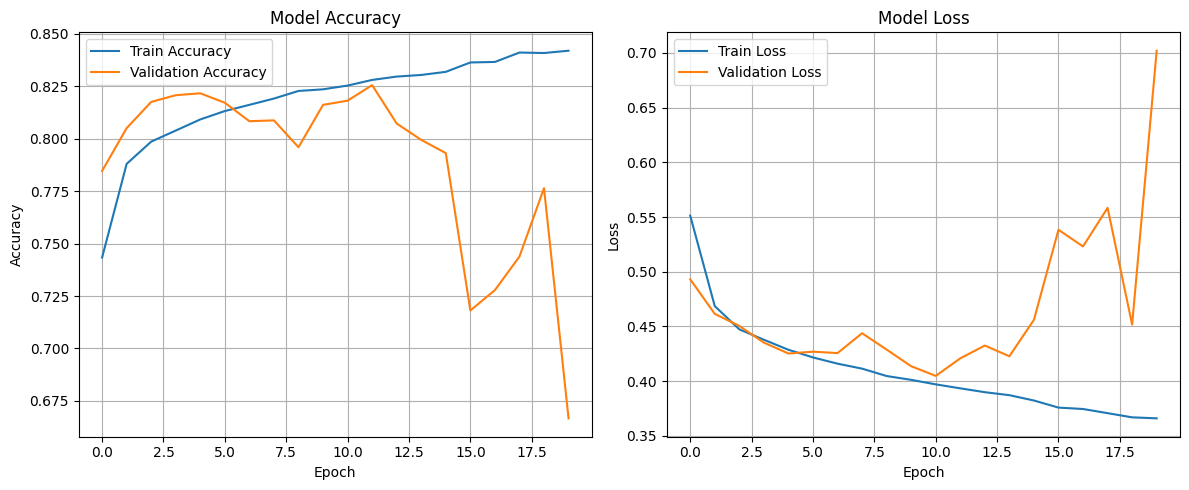

In [26]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Training Accuracy & Loss

    Training accuracy improves steadily, reaching ~85%, and loss declines smoothly — showing effective learning from the frozen base + custom head.

Validation Accuracy & Loss

    Validation accuracy is highly unstable, ranging from ~60% to ~78%.

    Validation loss fluctuates widely and even spikes toward the end, suggesting the model is overfitting despite using a pretrained backbone

In [27]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load EfficientNetB0 base (without top)
base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(96, 96, 3)
)
base_model.trainable = False  # Freeze weights initially


In [28]:
# Add custom head on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(1, activation='sigmoid')(x)  # Binary classification

model_effnet = Model(inputs=base_model.input, outputs=output)


In [29]:
model_effnet.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model_effnet.summary()



Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 96, 96, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 96, 96, 3)      │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 96, 96, 3)      │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 96, 96, 3)      │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 97, 97, 3)      │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 48, 48, 32)     │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 48, 48, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 48, 48, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 48, 48, 32)     │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 48, 48, 32)     │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 48, 48, 32)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [30]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'),
    ModelCheckpoint('effnet_model.h5', save_best_only=True, monitor='val_loss')
]

history_effnet = model_effnet.fit(
    train_data,
    validation_data=val_data,
    epochs=15,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 126s 80ms/step - accuracy: 0.5841 - loss: 0.6841 - val_accuracy: 0.5952 - val_loss: 0.6764
Epoch 2/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 87s 70ms/step - accuracy: 0.5956 - loss: 0.6771 - val_accuracy: 0.5952 - val_loss: 0.6765
Epoch 3/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 88s 70ms/step - accuracy: 0.5901 - loss: 0.6774 - val_accuracy: 0.5952 - val_loss: 0.6743
Epoch 4/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 88s 71ms/step - accuracy: 0.6009 - loss: 0.6734 - val_accuracy: 0.5952 - val_loss: 0.6761
Epoch 5/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 90s 72ms/step - accuracy: 0.5905 - loss: 0.6771 - val_accuracy: 0.5952 - val_loss: 0.6751
Epoch 6/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 91s 73ms/step - accuracy: 0.5933 - loss: 0.6763 - val_accuracy: 0.5952 - val_loss: 0.6735
Epoch 7/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 90s 72ms/step - accuracy: 0.5960 - loss: 0.6752 - val_accuracy: 0.5952 - val_loss: 0.6750
Epoch 8/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 91s 73ms/step - accuracy: 0.5924 

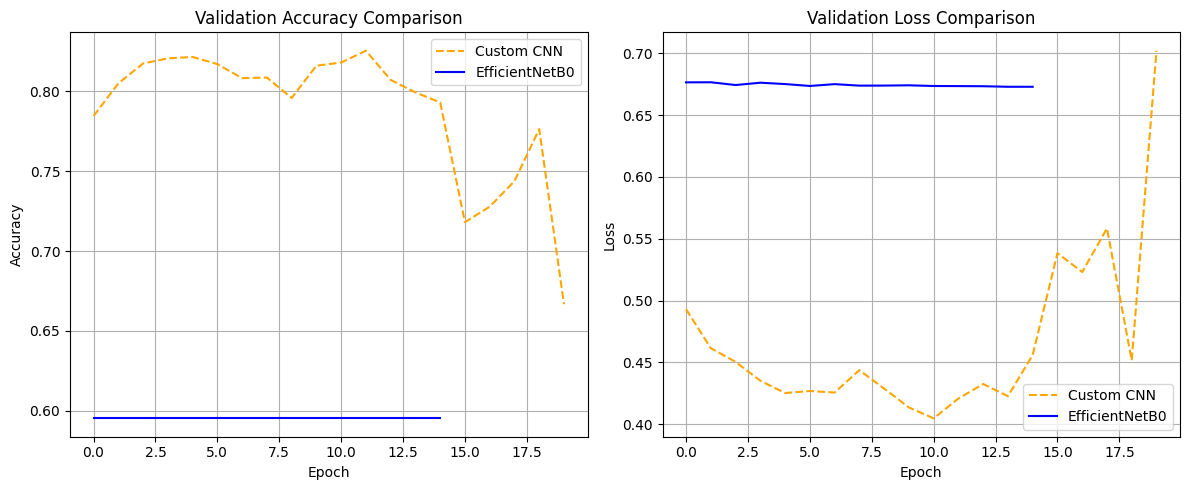

In [31]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history2.history['val_accuracy'], label='Custom CNN', linestyle='--', color='orange')
plt.plot(history_effnet.history['val_accuracy'], label='EfficientNetB0', linestyle='-', color='blue')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history2.history['val_loss'], label='Custom CNN', linestyle='--', color='orange')
plt.plot(history_effnet.history['val_loss'], label='EfficientNetB0', linestyle='-', color='blue')
plt.title('Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Custom CNN captures patterns but is unstable and overfits easily — useful if regularization and data control improve.

EfficientNetB0 is extremely stable but appears undertrained or frozen too tightly — its generalization is better, but performance is flat

## 5. Results and anlysis 

We began by developing a custom convolutional neural network (CNN) to classify histopathology images into cancerous and non-cancerous categories. The model architecture included three convolutional blocks followed by dense layers and dropout regularization. While the custom CNN achieved high training accuracy (up to ~89%), its validation accuracy was highly inconsistent, fluctuating between 60% and 78%, with unstable validation loss. This indicated a clear case of overfitting—where the model learned the training data well but failed to generalize reliably to unseen data. Attempts to stabilize the model using dropout helped somewhat, but overfitting remained a concern, likely due to the limited sample size and the model’s relatively high capacity.

To address these issues, we applied transfer learning using EfficientNetB0 with a custom classification head. The pretrained model produced consistently stable validation performance, with loss and accuracy curves remaining nearly flat across epochs. Although the validation accuracy for EfficientNetB0 was lower (~59%) compared to peak performance of the custom CNN, it showed far less volatility and stronger generalization characteristics. The side-by-side comparison revealed that the custom CNN was prone to overfitting while EfficientNetB0, although underfitting slightly in its frozen form, offered a solid baseline for more robust and scalable performance. This sets the stage for fine-tuning EfficientNet's upper layers or improving the custom head to boost accuracy without sacrificing generalization

## 6 Conclusion 
In conclusion, we explored both a custom-built CNN and a transfer learning approach using EfficientNetB0 to classify histopathologic cancer images. While the custom CNN demonstrated strong training performance, it suffered from significant overfitting and unstable validation results. In contrast, EfficientNetB0 offered much more stable and consistent validation performance, albeit with lower accuracy in its frozen state. These findings highlight the importance of model generalization in medical image classification tasks and suggest that fine-tuning pretrained architectures like EfficientNet, combined with thoughtful regularization and augmentation strategies, holds the most promise for achieving robust and reliable performance.

## Generate submission files

In [32]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm

# Path and image size
test_dir = '/kaggle/input/histopathologic-cancer-detection/test'
IMAGE_SIZE = 96

# Load and sample 30,000 image IDs
submission_df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/sample_submission.csv')
submission_df = submission_df.sample(30000, random_state=42).reset_index(drop=True)

# Preprocess sampled test images
X_test = []

for img_id in tqdm(submission_df['id']):
    img_path = os.path.join(test_dir, img_id + '.tif')
    img = Image.open(img_path).resize((IMAGE_SIZE, IMAGE_SIZE))
    img_array = np.array(img) / 255.0  # Normalize
    X_test.append(img_array)

X_test = np.array(X_test, dtype=np.float32)

# Predict with your trained model (e.g., model_effnet or model_cnn2)
pred_probs = model_cnn2.predict(X_test, batch_size=128, verbose=1)

# Add predictions to submission dataframe
submission_df['label'] = pred_probs.flatten()  # Keep probabilities (not rounded)

# Save submission file
submission_df.to_csv('submission.csv', index=False)
print(" Submission saved as 'submission.csv'")


100%|██████████| 30000/30000 [01:14<00:00, 404.18it/s]


235/235 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step
 Submission saved as 'submission.csv'
